In [16]:
import pandas as pd
import numpy as np
import json
import math

import matplotlib.pyplot as plt
import seaborn as sns

In [17]:
portfolio = pd.read_json('portfolio.json', orient = 'records', lines = True)
profile = pd.read_json('profile.json', orient = 'records', lines = True)
transcript = pd.read_json('transcript.json', orient = 'records', lines = True)

# Data Preparation
## Portfolio
Portfolio dataset contain informations about campaign informations that sent customers.

In [18]:
print(f'Portfolio have {portfolio.shape[0]} rows and {portfolio.shape[1]} columns')
portfolio

Portfolio have 10 rows and 6 columns


,reward,channels,difficulty,duration,offer_type,id
0,10,"[email, mobile, social]",10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd
1,10,"[web, email, mobile, social]",10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0
2,0,"[web, email, mobile]",0,4,informational,3f207df678b143eea3cee63160fa8bed
3,5,"[web, email, mobile]",5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9
4,5,"[web, email]",20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7
5,3,"[web, email, mobile, social]",7,7,discount,2298d6c36e964ae4a3e7e9706d1fb8c2
6,2,"[web, email, mobile, social]",10,10,discount,fafdcd668e3743c1bb461111dcafc2a4
7,0,"[email, mobile, social]",0,3,informational,5a8bc65990b245e5a138643cd4eb9837
8,5,"[web, email, mobile, social]",5,5,bogo,f19421c1d4aa40978ebb69ca19b0e20d
9,2,"[web, email, mobile]",10,7,discount,2906b810c7d4411798c6938adc9daaa5


1. Split the `channel` column in to 4 columns for further data modelling.<br/>
*Email, Mobile, Social, Web*
2. Perform one-hot encoder for `offer_type`

In [19]:
# Create onehot columns for channels by extract string and joining with | symbols
channel_onehot = portfolio['channels'].str.join('|').str.get_dummies().add_prefix('channel_')

# Join channel_onehot into main dataset and drop the origial channels column
portfolio = portfolio.join(channel_onehot)
portfolio.drop(['channels'], axis = 1, inplace = True)

# Transform offer_type into one-hot columns
portfolio = portfolio.join(pd.get_dummies(portfolio.pop('offer_type')).add_prefix('offer_type_'))


In [20]:
portfolio

,reward,difficulty,duration,id,channel_email,channel_mobile,channel_social,channel_web,offer_type_bogo,offer_type_discount,offer_type_informational
0,10,10,7,ae264e3637204a6fb9bb56bc8210ddfd,1,1,1,0,1,0,0
1,10,10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,1,1,1,1,1,0,0
2,0,0,4,3f207df678b143eea3cee63160fa8bed,1,1,0,1,0,0,1
3,5,5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,1,1,0,1,1,0,0
4,5,20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,1,0,0,1,0,1,0
5,3,7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,1,1,1,1,0,1,0
6,2,10,10,fafdcd668e3743c1bb461111dcafc2a4,1,1,1,1,0,1,0
7,0,0,3,5a8bc65990b245e5a138643cd4eb9837,1,1,1,0,0,0,1
8,5,5,5,f19421c1d4aa40978ebb69ca19b0e20d,1,1,1,1,1,0,0
9,2,10,7,2906b810c7d4411798c6938adc9daaa5,1,1,0,1,0,1,0


## Profile
Profile dataset contain demographic information for each customer on rewards program.

In [21]:
print(f'Profile have {profile.shape[0]} rows and {profile.shape[1]} columns')
profile.head(10)

Profile have 17000 rows and 5 columns


,gender,age,id,became_member_on,income
0,None,118,68be06ca386d4c31939f3a4f0e3dd783,20170212,NaN
1,F,55,0610b486422d4921ae7d2bf64640c50b,20170715,112000.0
2,None,118,38fe809add3b4fcf9315a9694bb96ff5,20180712,NaN
3,F,75,78afa995795e4d85b5d9ceeca43f5fef,20170509,100000.0
4,None,118,a03223e636434f42ac4c3df47e8bac43,20170804,NaN
5,M,68,e2127556f4f64592b11af22de27a7932,20180426,70000.0
6,None,118,8ec6ce2a7e7949b1bf142def7d0e0586,20170925,NaN
7,None,118,68617ca6246f4fbc85e91a2a49552598,20171002,NaN
8,M,65,389bc3fa690240e798340f5a15918d5c,20180209,53000.0
9,None,118,8974fc5686fe429db53ddde067b88302,20161122,NaN


Convert `became_member_on` to datetime format. <br/>
Create `became_member_on_long` as a long type number for continuous representation.

In [7]:
profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format = '%Y%m%d')
profile['became_member_on_long'] = profile.became_member_on.astype(np.long)

In [8]:
profile.sort_values('became_member_on_long')

,gender,age,id,became_member_on,income,became_member_on_long
8948,M,64,77388a70eaf14433b4efc5d01fa947bf,2013-07-29,69000.0,1375056000000000000
7796,F,58,d25f38519a89455499c9e49e67ae1511,2013-07-30,55000.0,1375142400000000000
1200,M,52,5ffdab087e674149a89324a732b4f993,2013-07-30,65000.0,1375142400000000000
569,M,36,dbb4766b7dd94ca2b83a855312a3ebe9,2013-07-30,74000.0,1375142400000000000
10933,F,67,7b42b5bbe237406aaf2748a09050f745,2013-07-31,58000.0,1375228800000000000
...,...,...,...,...,...,...
8079,M,82,039e0c539c2f4fc582423412a8bceb40,2018-07-26,32000.0,1532563200000000000
12326,F,59,3b9ec536e4224688950913b9cf53362c,2018-07-26,88000.0,1532563200000000000
10282,M,46,e4989ca3d8974e28a3fe87aa0b0ce327,2018-07-26,74000.0,1532563200000000000
12902,M,85,f1f01be4e2344bf08b7f488c115ad374,2018-07-26,45000.0,1532563200000000000


### Check missing value
Find out that `Gender` and `Income` have missing on the same positions with some reason.

In [9]:
profile.isna().mean()*100

gender                   12.794118
age                       0.000000
id                        0.000000
became_member_on          0.000000
income                   12.794118
became_member_on_long     0.000000
dtype: float64

- For missing value in `gender`, **unknown (U)** will be impute into missing positions.
- For missing value in `income`, mean imputation will be used.

In [25]:
profile['gender'].fillna('U', inplace = True)
profile['income'].fillna(profile['income'].mean(), inplace = True)

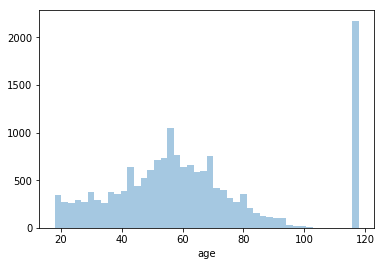

In [10]:
sns.distplot(profile['age'],kde = False)
plt.show()

## Transcript

In [11]:
print(f'Portfolio have {transcript.shape[0]} rows and {transcript.shape[1]} columns')
transcript

Portfolio have 306534 rows and 4 columns


,person,event,value,time
0,78afa995795e4d85b5d9ceeca43f5fef,offer received,{'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'},0
1,a03223e636434f42ac4c3df47e8bac43,offer received,{'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'},0
2,e2127556f4f64592b11af22de27a7932,offer received,{'offer id': '2906b810c7d4411798c6938adc9daaa5'},0
3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,{'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'},0
4,68617ca6246f4fbc85e91a2a49552598,offer received,{'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'},0
...,...,...,...,...
306529,b3a1272bc9904337b331bf348c3e8c17,transaction,{'amount': 1.5899999999999999},714
306530,68213b08d99a4ae1b0dcb72aebd9aa35,transaction,{'amount': 9.53},714
306531,a00058cf10334a308c68e7631c529907,transaction,{'amount': 3.61},714
306532,76ddbd6576844afe811f1a3c0fbb5bec,transaction,{'amount': 3.5300000000000002},714


In [13]:
transcript['event'].value_counts()

transaction        138953
offer received      76277
offer viewed        57725
offer completed     33579
Name: event, dtype: int64

In [33]:
transcript.isna().mean()*100

person    0.0
event     0.0
value     0.0
time      0.0
dtype: float64